# Competition and Dataset Overview

The competition task is to predict whether a person is an Introvert or Extrovert based on their social behavior and personality trait metrics (binary classification). The dataset was synthetically generated using a deep learning model trained on an actual “Extrovert vs. Introvert Behavior” survey dataset (meaning the competition data mirrors real survey patterns). Each person in the data has several features describing their behavior/traits, and a target label Personality indicating Introvert or Extrovert.

## Dataset Overview

Performing a thorough EDA will help understand the data distribution, feature relationships, and potential data issues before modeling. Confirm which features are numeric vs categorical. This helps plan appropriate visualizations.

Let's do it below:

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)


df= pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


## Removing Runtime Warning

We can see that our data has missing values (NaN) in several float64 columns. That’s exactly what causes the warning from pandas' formatter — it tries to compare NaN values to numbers during output.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


## Which features differ the most between introverts and extroverts?

* All 5 features differ **strongly** between introverts and extroverts (values > 1.0).
* **Time_spent_Alone** shows the largest standardized difference, making it the most distinguishing feature between the two groups.

In [3]:
df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [4]:
group_means = df.groupby('Personality')[[
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]].mean()

numeric_cols = [
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]

print(abs(group_means.loc['Extrovert'] - group_means.loc['Introvert']) / df[numeric_cols].std())

Time_spent_Alone           1.766035
Social_event_attendance    1.618114
Going_outside              1.629880
Friends_circle_size        1.506023
Post_frequency             1.563780
dtype: float64


## Target Class Balance

We should ensure the classifier doesn't simply predict the majority class. So we need strategies to handle class imbalanced in the dataset.

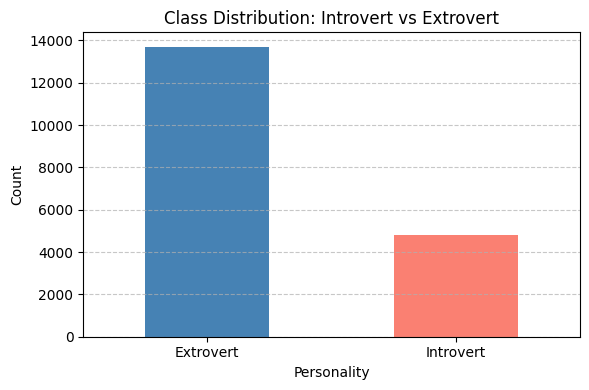


Percentage distribution:
 Personality
Extrovert    73.95
Introvert    26.05
Name: count, dtype: float64


In [5]:
class_counts = df['Personality'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['steelblue', 'salmon'])
plt.title('Class Distribution: Introvert vs Extrovert')
plt.ylabel('Count')
plt.xlabel('Personality')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

percentages = class_counts / class_counts.sum() * 100
print("\nPercentage distribution:\n", percentages.round(2))

## Missing Values Analysis

As noted, **preliminary info suggests Stage_fear NaNs might be more common for Introverts is right**.

In [6]:
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
})
print("Missing values overview:\n", missing_df)

# 2. Investigate if Stage_fear missingness is class-specific
missing_stage_fear = df[df['Stage_fear'].isnull()]
total_introverts = df[df['Personality'] == 'Introvert']
total_extroverts = df[df['Personality'] == 'Extrovert']

introvert_missing_pct = (
    missing_stage_fear['Personality'].value_counts().get('Introvert', 0) /
    len(total_introverts) * 100
)

extrovert_missing_pct = (
    missing_stage_fear['Personality'].value_counts().get('Extrovert', 0) /
    len(total_extroverts) * 100
)

print(f"Introverts missing Stage_fear: {introvert_missing_pct:.2f}%")
print(f"Extroverts missing Stage_fear: {extrovert_missing_pct:.2f}%")

Missing values overview:
                            Missing Count  Missing %
id                                     0       0.00
Time_spent_Alone                    1190       6.42
Stage_fear                          1893      10.22
Social_event_attendance             1180       6.37
Going_outside                       1466       7.91
Drained_after_socializing           1149       6.20
Friends_circle_size                 1054       5.69
Post_frequency                      1264       6.82
Personality                            0       0.00
Introverts missing Stage_fear: 15.42%
Extroverts missing Stage_fear: 8.39%


In [7]:
df['Stage_fear_missing'] = df['Stage_fear'].isnull().astype(int)
df['Stage_fear'] = df['Stage_fear'].fillna("Missing")

## Feature vs. Target Relationships

For each feature, we can examine how it relates to the target Introvert/Extrovert. 

* For numeric features, one approach is to plot kernel density estimates (KDE) or overlapping histograms for the two classes. This can reveal if introverts and extroverts have different distributions for a given trait.

* For categorical features, we can create a contingency table or stacked bar chart. This could uncover patterns (maybe a higher proportion of introverts report stage fear = Yes compared to extroverts

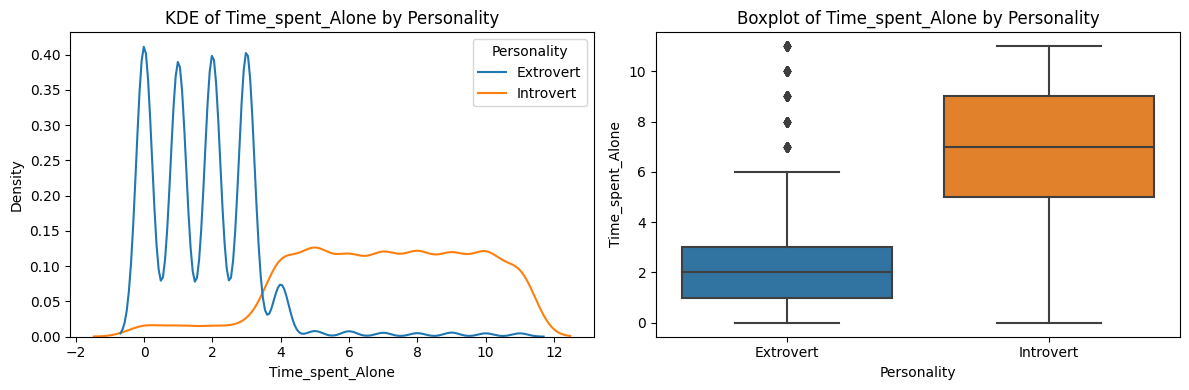

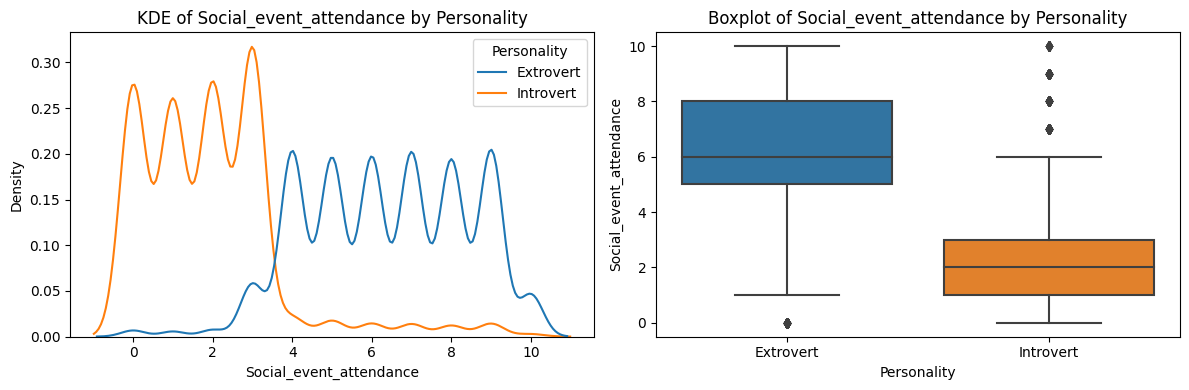

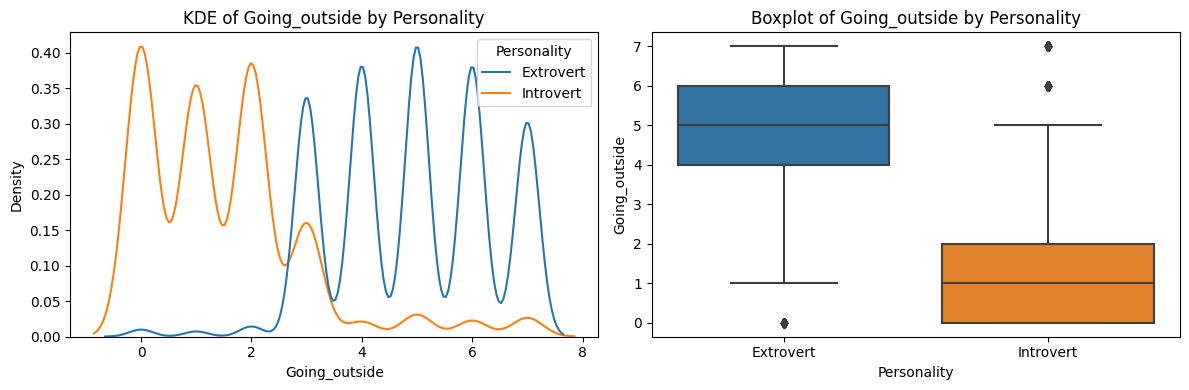

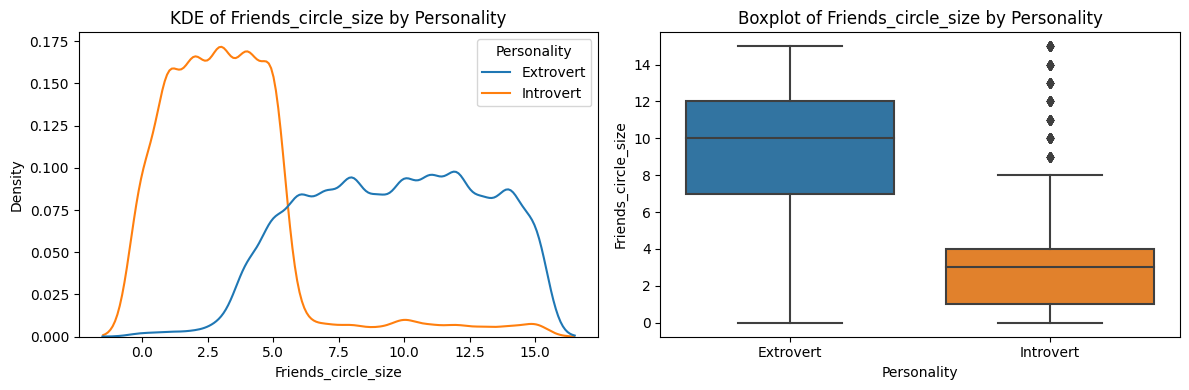

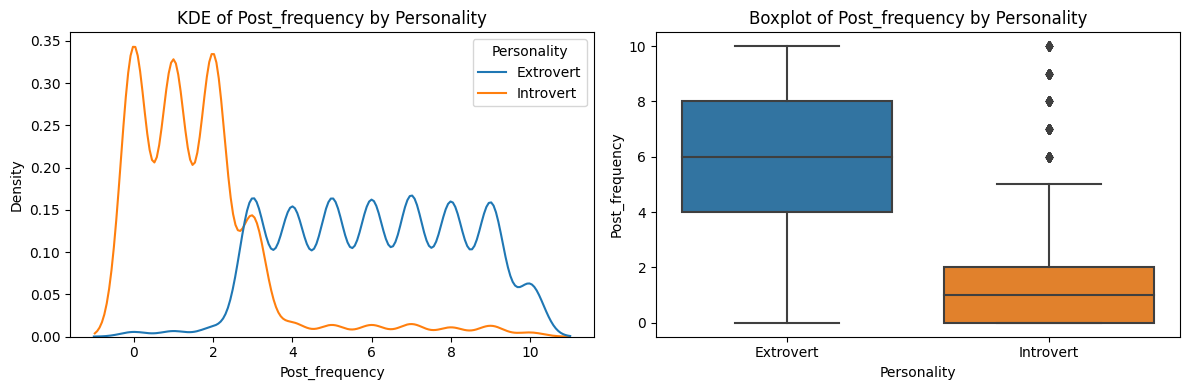

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define numeric features
numeric_features = df.select_dtypes(include='float64').columns

# KDE and boxplots for each numeric feature
for col in numeric_features:
    plt.figure(figsize=(12, 4))

    # KDE Plot
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=df, x=col, hue="Personality", common_norm=False)
    plt.title(f'KDE of {col} by Personality')

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x="Personality", y=col)
    plt.title(f'Boxplot of {col} by Personality')

    plt.tight_layout()
    plt.show()


## Correlation Analysis

 Compute the correlation matrix for numeric features with a heatmap. If **some features are very strongly correlated** (say r > 0.8), we might consider dimensionality reduction or dropping one to simplify the model. Also consider calculating the correlation of each numeric feature with the target (if we encode Introvert=0, Extrovert=1 or similar). Though the target is binary, Pearson or point-biserial correlation can indicate which features have the strongest linear relationship with being extrovert vs introvert.

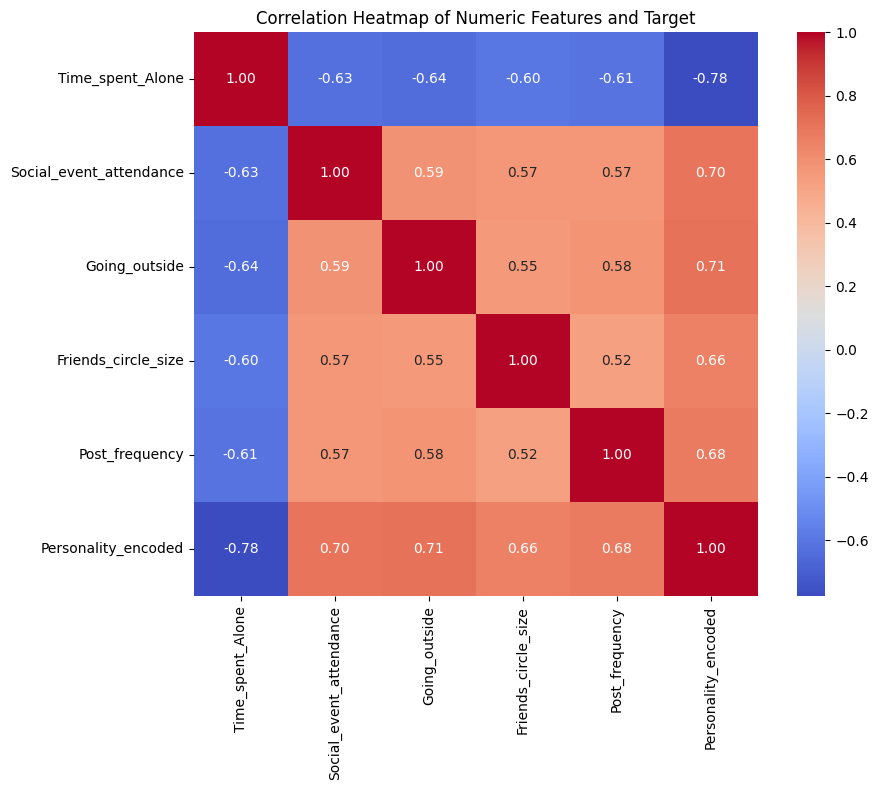

In [9]:
# Encode the target variable
df['Personality_encoded'] = df['Personality'].map({'Introvert': 0, 'Extrovert': 1})

# Select numeric features
numeric_features = [
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]

# Compute the correlation matrix (including correlation with target)
corr_matrix = df[numeric_features + ['Personality_encoded']].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numeric Features and Target')
plt.tight_layout()
plt.show()


## Dimensionality Reduction (PCA)

We can apply Principal Component Analysis (PCA) on the dataset to see overall structure.

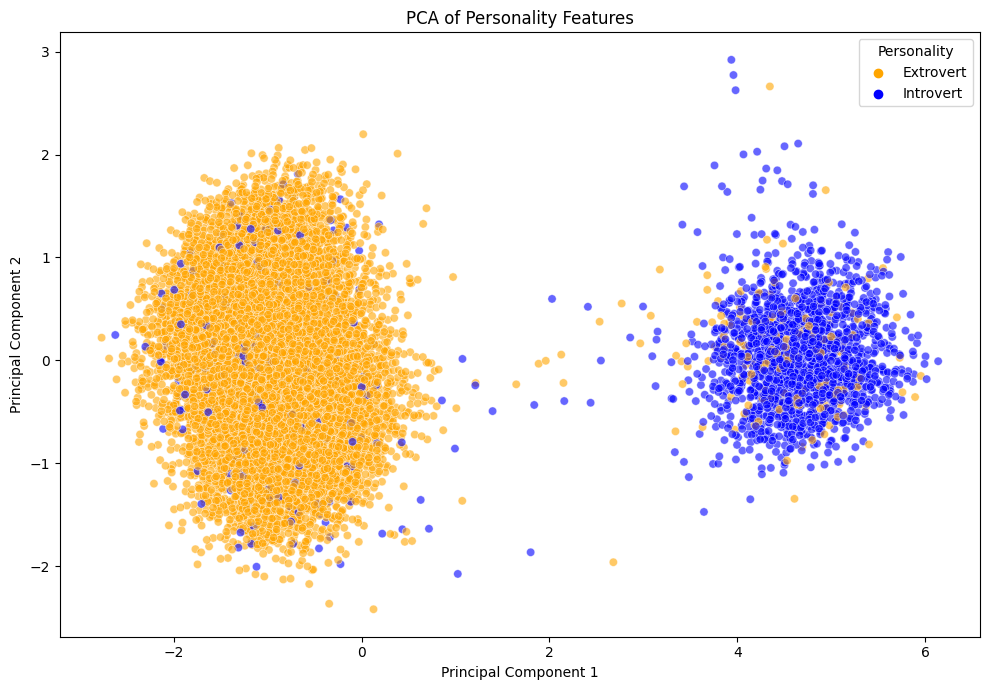

In [10]:
features = [
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency',
    'Stage_fear',
    'Drained_after_socializing',
    'Personality'
]
df_pca = df[features].copy()

binary_map = {'Yes': 1, 'No': 0}
df_pca['Stage_fear'] = df_pca['Stage_fear'].map(binary_map)
df_pca['Drained_after_socializing'] = df_pca['Drained_after_socializing'].map(binary_map)
df_pca['Personality_encoded'] = df_pca['Personality'].map({'Introvert': 0, 'Extrovert': 1})

df_pca = df_pca.dropna()

X = df_pca.drop(columns=['Personality', 'Personality_encoded'])
X_scaled = StandardScaler().fit_transform(X)
y = df_pca['Personality']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Personality'] = y.values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Personality',
                palette={'Introvert': 'blue', 'Extrovert': 'orange'}, alpha=0.6)
plt.title('PCA of Personality Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Personality')
plt.tight_layout()
plt.show()

# Modeling Approach: Traditional ML vs. Neural Network

After EDA, we need to select a modeling strategy to predict Introvert/Extrovert. We have two broad approaches: classic machine learning models or a neural network model. We will consider both in terms of effectiveness and efficiency, and decide on the best path (or use both complementary).

## Traditional Machine Learning Models

For tabular data with mixed numeric and categorical features (like this dataset), traditional supervised learning algorithms are often very effective. Some candidates include:

* **Logistic Regression:** A simple baseline for binary classification. It’s fast and gives interpretable coefficients. However, logistic regression can underfit if the true relationships are non-linear or involve interactions between features.
* **Decision Trees and Ensemble Trees:** Decision tree-based models can capture non-linear relationships and interactions naturally. In particular, ensemble methods like Random Forest or Gradient Boosted Trees (e.g. XGBoost, LightGBM) have a strong track record for tabular data.
* **Support Vector Machine (SVM):** SVMs can perform well on binary classification, especially if the data is reasonably scaled and not too large. An SVM with an RBF kernel could model non-linear boundaries between introverts/extroverts. However, SVMs can be slower on larger datasets and require careful tuning of the kernel parameters.
* **k-Nearest Neighbors, Naive Bayes, etc.:** These are less likely to be top performers for this task. kNN is not very efficient at scale and doesn’t handle mixed feature types gracefully, and Naive Bayes assumes feature independence (which is likely violated here). They are generally not the go-to for this kind of problem.

### Summary of our setup:
* **Target**: Personality (will encode: Extrovert=1, Introvert=0)
* **Features**: All columns except id and Personality
* **Categoricals**: Not yet encoded (we’ll handle Stage_fear, Drained_after_socializing as binary)
* **Missing values**: Impute median
* **Class imbalance**: Extrovert 74%, Introvert 26% (we’ll handle with scale_pos_weight)
* **Model**: XGBoost

In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Encode target
df['Personality_encoded'] = df['Personality'].map({'Introvert': 0, 'Extrovert': 1})

# Encode categorical features
for col in ['Stage_fear', 'Drained_after_socializing']:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
    df_test[col] = df_test[col].map({'Yes': 1, 'No': 0})

features = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
    'Going_outside', 'Drained_after_socializing',
    'Friends_circle_size', 'Post_frequency'
]
X_train = df[features]
y_train = df['Personality_encoded']
X_test = df_test[features]

# Impute missing values (fit on train, apply to both train and test)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Handle class imbalance
n_extrovert = sum(y_train == 1)
n_introvert = sum(y_train == 0)
scale_pos_weight = n_introvert / n_extrovert

# XGBoost model setup
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.08,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# ---- 1. Cross-validation (evaluate model) ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb, X_train_imputed, y_train, cv=cv, scoring='roc_auc')
print(f'Cross-Validation ROC AUC scores: {cv_scores}')
print(f'Mean CV ROC AUC: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}')

# ---- 2. Train final model on all training data ----
xgb.fit(X_train_imputed, y_train)

# ---- 3. Predict on test data ----
test_pred_proba = xgb.predict_proba(X_test_imputed)[:, 1]  # Probability of Extrovert
test_pred_class = xgb.predict(X_test_imputed)  # 0/1

# Add results to test DataFrame
df_test['Extrovert_Probability'] = test_pred_proba
df_test['Predicted_Personality'] = np.where(test_pred_class == 1, 'Extrovert', 'Introvert')

print(df_test[['Extrovert_Probability', 'Predicted_Personality']].head())

Cross-Validation ROC AUC scores: [0.97070686 0.9659317  0.96103438 0.96837298 0.97195962]
Mean CV ROC AUC: 0.9676 +/- 0.0039
   Extrovert_Probability Predicted_Personality
0               0.980880             Extrovert
1               0.007236             Introvert
2               0.875776             Extrovert
3               0.978949             Extrovert
4               0.010584             Introvert


## Submission

Ensure the output is in the correct format for Kaggle submission

In [12]:
submission = df_test[['id', 'Predicted_Personality']].rename(columns={'Predicted_Personality': 'Personality'})

# Double-check row count matches test set
assert submission.shape[0] == df_test.shape[0], "Submission row count does not match test set!"

# Save as 'submission.csv' with header, no index
submission.to_csv('submission.csv', index=False)